## 1. GRU
 - Gated Recurrent Unit
 - LSTM의 복잡한 구조를 단순화: 기존 출력/입력/삭제 게이트를 업데이트와 리셋 게이트로 정리
 - 속도 개선, 성능은 유지

In [ ]:
!pip install -U pykrx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 4.0 MB/s 
     |████████████████████████████████| 52 kB 1.1 MB/s 
     |████████████████████████████████| 254 kB 28.5 MB/s 
     |████████████████████████████████| 15.7 MB 71.6 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.16.2
    Uninstalling numpy-1.16.2:
      Successfully uninstalled numpy-1.16.2


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from pykrx import stock

stock1 = stock.get_market_ticker_name("000660")
stock1

stocks = stock.get_market_ohlcv_by_date("20210104", "20211231", "005930")

In [ ]:
stocks.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'amount','change']
stocks["date"] = stocks.index

In [ ]:
stocks['date'] = pd.to_datetime(stocks['date'], format='%Y%m%d')
stocks['year'] = stocks['date'].dt.year

In [ ]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stocks['Volume'], x=stocks['Close'])
plt.xlabel('time')
plt.ylabel('price')

In [ ]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stocks['Close'], x=stocks['date'])
plt.xlabel('time')
plt.ylabel('price')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

stocks.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols =  ['Open', 'High', 'Low', 'Close', 'Volume', 'amount']
df_scaled = scaler.fit_transform(stocks[scale_cols])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

df_scaled

Open      High       Low     Close    Volume    amount
0    0.569444  0.544118  0.561321  0.639640  0.369920  0.333152
1    0.597222  0.525735  0.627358  0.680180  0.329425  0.298520
2    0.675926  0.547794  0.650943  0.603604  0.411808  0.374436
3    0.652778  0.536765  0.679245  0.635135  0.296598  0.274189
4    0.675926  0.750000  0.693396  0.900901  0.618264  0.576913
..        ...       ...       ...       ...       ...       ...
243  0.532407  0.411765  0.561321  0.527027  0.045812  0.049190
244  0.550926  0.404412  0.542453  0.513514  0.029916  0.035153
245  0.532407  0.397059  0.537736  0.518018  0.120712  0.111400
246  0.532407  0.389706  0.481132  0.450450  0.139845  0.125631
247  0.472222  0.363971  0.462264  0.427928  0.072043  0.068074

[248 rows x 6 columns]

In [ ]:
#Window size: 과거 몇 기간의 데이터로 예측을 할 것인지 지정
TEST_SIZE = 20
WINDOW_SIZE = 10

train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

def make_dataset(data, label, window_size=10):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [ ]:
from sklearn.model_selection import train_test_split

feature_cols = ['Open', 'High', 'Low', 'Volume', 'amount']
label_cols = ['Close']

train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 10)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
x_train.shape, x_valid.shape

((174, 10, 5), (44, 10, 5))

In [ ]:
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape

test_feature, test_label = make_dataset(test_feature, test_label, 10)
test_feature.shape, test_label.shape

((10, 10, 5), (10, 1))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM, GRU

model = Sequential()
model.add(GRU(16,
               input_shape=(train_feature.shape[1], train_feature.shape[2]),
               activation='relu',
               return_sequences=False)
          )
model.add(Dense(1))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(x_train, y_train,
                                    epochs=200,  #200
                                    batch_size=16,
                                    validation_data=(x_valid, y_valid))

Epoch 1/200
11/11 [==============================] - 1s 36ms/step - loss: 0.1293 - val_loss: 0.0602
Epoch 2/200
11/11 [==============================] - 0s 20ms/step - loss: 0.0476 - val_loss: 0.0179
Epoch 3/200
11/11 [==============================] - 0s 19ms/step - loss: 0.0162 - val_loss: 0.0083
Epoch 4/200
11/11 [==============================] - 0s 19ms/step - loss: 0.0086 - val_loss: 0.0097
Epoch 5/200
11/11 [==============================] - 0s 20ms/step - loss: 0.0077 - val_loss: 0.0092
Epoch 6/200
11/11 [==============================] - 0s 19ms/step - loss: 0.0054 - val_loss: 0.0057
Epoch 7/200
11/11 [==============================] - 0s 20ms/step - loss: 0.0041 - val_loss: 0.0044
Epoch 8/200
11/11 [==============================] - 0s 20ms/step - loss: 0.0034 - val_loss: 0.0046
Epoch 9/200
11/11 [==============================] - 0s 19ms/step - loss: 0.0032 - val_loss: 0.0053
Epoch 10/200
11/11 [==============================] - 0s 19ms/step - loss: 0.0031 - val_loss: 0.0047

In [ ]:
test_feature.shape

(10, 10, 5)

In [ ]:
pred = model.predict(test_feature)
pred.shape

1/1 [==============================] - 0s 140ms/step


(10, 1)

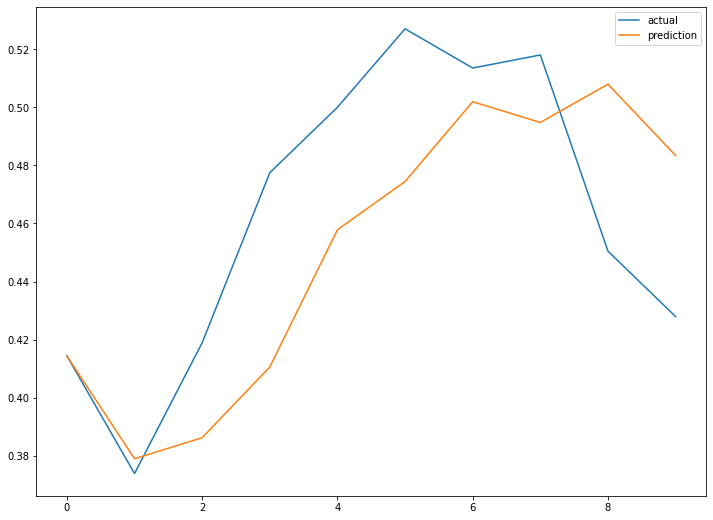

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()

##2. 하이퍼 파라미터 튜닝
 - DNN의 하이터파라미터: 층의 수, 노드의 수, 학습율, 배치크기 등
 - RadomizedSerachCV 또는 GridSearchCV 등 활용

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 135 kB 4.2 MB/s 
     |████████████████████████████████| 1.6 MB 38.1 MB/s 


In [ ]:
import keras_tuner as kt

In [ ]:
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
# Normalize pixel values between 0 and 1
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

- 하이퍼튜닝을 위한 모형 구축 시 하이퍼 파라미터 탐색 공간 정의
- 하이퍼 모델: 하이퍼튜닝을 위해 설정하는 모델

- 하이퍼 모형의 설정
 - 모델 빌더 함수 사용: Keras Tuner API의 HyperModel 클래스를 하위 클래스화
 - 컴파일된 모델을 반환하고 인라인으로 정의한 하이퍼파라미터를 사용하여 모델을 하이퍼튜닝

In [ ]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(10))

  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

- tuner 객체 만들고 튜닝 수행
 - randomsearch, hyperband, bayesianoptimization, sklearn 등의 tuner 가능
 - Hyperband 사용 시: objective와 epoch 지정

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [ ]:
class ClearTrainingOutput(tf.keras.callbacks.Callback): #조기 학습 중단을 위해 사용
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:
#하이퍼 파라미터 탐색 실행
tuner.search(img_train, label_train, epochs=50, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
optimal number of units:  {best_hps.get('units')}
optimal learning rate for the optimizer:  {best_hps.get('learning_rate')}
""")

Trial 30 Complete [00h 00m 39s]
val_accuracy: 0.875333309173584

Best val_accuracy So Far: 0.8794999718666077
Total elapsed time: 00h 06m 27s

optimal number of units:  192 
optimal learning rate for the optimizer:  0.001



In [ ]:
#탐색을 통해 찾은 하이퍼파라미터로 훈련 시 최적의 epoch을 발견
model = tuner.hypermodel.build(best_hps)
history = model.fit(img_train, label_train, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
1500/1500 [==============================] - 4s 2ms/step - loss: 0.5146 - accuracy: 0.8176 - val_loss: 0.4004 - val_accuracy: 0.8553
Epoch 2/50
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3801 - accuracy: 0.8635 - val_loss: 0.4033 - val_accuracy: 0.8493
Epoch 3/50
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3408 - accuracy: 0.8737 - val_loss: 0.3405 - val_accuracy: 0.8801
Epoch 4/50
1500/1500 [==============================] - 4s 2ms/step - loss: 0.3143 - accuracy: 0.8847 - val_loss: 0.3471 - val_accuracy: 0.8798
Epoch 5/50
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2954 - accuracy: 0.8906 - val_loss: 0.3227 - val_accuracy: 0.8848
Epoch 6/50
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2785 - accuracy: 0.8977 - val_loss: 0.3397 - val_accuracy: 0.8797
Epoch 7/50
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2669 - accuracy: 0.9013 - val_loss: 0.3118 - val_accuracy:

In [ ]:
#최적 모형 객체 만들기
hypermodel = tuner.hypermodel.build(best_hps)

# 최적 epoch으로 학습
hypermodel.fit(img_train, label_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/47
1500/1500 [==============================] - 4s 2ms/step - loss: 0.5070 - accuracy: 0.8205 - val_loss: 0.4087 - val_accuracy: 0.8578
Epoch 2/47
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3757 - accuracy: 0.8628 - val_loss: 0.4022 - val_accuracy: 0.8532
Epoch 3/47
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3400 - accuracy: 0.8753 - val_loss: 0.3597 - val_accuracy: 0.8720
Epoch 4/47
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3133 - accuracy: 0.8837 - val_loss: 0.3284 - val_accuracy: 0.8848
Epoch 5/47
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2947 - accuracy: 0.8901 - val_loss: 0.3564 - val_accuracy: 0.8758
Epoch 6/47
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2793 - accuracy: 0.8947 - val_loss: 0.3194 - val_accuracy: 0.8857
Epoch 7/47
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2654 - accuracy: 0.9009 - val_loss: 0.3179 - val_accuracy:

In [ ]:
eval_result = hypermodel.evaluate(img_test, label_test)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 1s 2ms/step - loss: 0.5419 - accuracy: 0.8872
[test loss, test accuracy]: [0.5419340133666992, 0.8871999979019165]
